In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## 1. MNIST train, test dataset 가져오기

In [2]:
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)


## 2. 대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label:  5


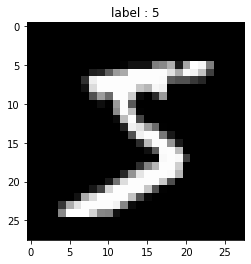

In [3]:
print("mnist_train 길이:", len(mnist_train))
print("mnist_test 길이:", len(mnist_test))

image, label = mnist_train.__getitem__(0)
print("image data 형태:", image.size())
print("label: ", label)

img = image.numpy()
plt.title("label : %d" %label)
plt.imshow(img[0], cmap="gray")
plt.show()


## 3. 데이터 로드함수

In [4]:
#hyper parameters
batch_size = 1024
learning_rate = 0.01
num_epoch = 400

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle=True, num_workers = 2, drop_last = True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size, shuffle=False, num_workers = 2, drop_last = True)


[0]
한 번에 로드되는 데이터 크기: 1024


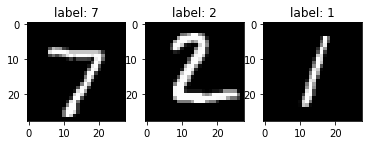

[1]
한 번에 로드되는 데이터 크기: 1024


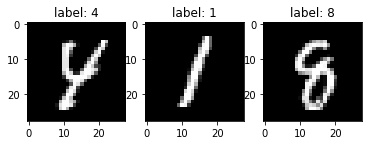

[2]
한 번에 로드되는 데이터 크기: 1024


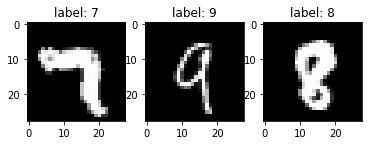

[3]
한 번에 로드되는 데이터 크기: 1024


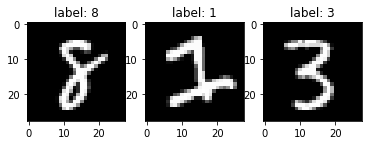

[4]
한 번에 로드되는 데이터 크기: 1024


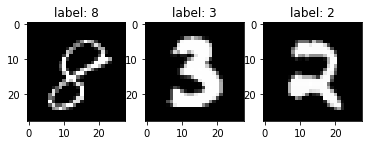

[5]
한 번에 로드되는 데이터 크기: 1024


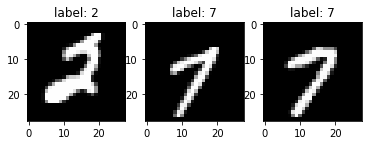

In [5]:

n=3
for i, [imgs, labels] in enumerate(test_loader):
    if i>5:
        break
    
    print("[%d]" %i)
    print("한 번에 로드되는 데이터 크기:", len(imgs))
    
    for j in range(n):
        img = imgs[j].numpy()
        img = img.reshape((img.shape[1], img.shape[2]))
        
        plt.subplot(1,n, j+1)
        plt.imshow(img, cmap="gray")
        plt.title("label: %d" %labels[j])
    plt.show()


## 4. 모델 선언

In [6]:
model = nn.Sequential(
    nn.Linear(28*28, 256), #linear --> fully connected
    nn.Sigmoid(),
    nn.Linear(256, 128),
    nn.Linear(128, 10),
)

#print(list(model.parameters())) #파라미터 보기 

In [7]:
#model = model.cuda() #gpu사용 옵션

In [8]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):
        img = imgs
        label = Variable(labels)
        
        img = img.reshape(img.shape[0], img.shape[2], img.shape[3])
        img = img.reshape(img.shape[0], img.shape[1]*img.shape[2])
        img = Variable(img, requires_grad = False)
        
        output = imodel(img)
        _, output_index = torch.max(output, 1) #(1024 , 10) 의 형태로 output을 (1024, 1)로 shrink시켜줌 
        #output : 1024개의 대한 결과 값
        
        total += label.size(0) #label --> (1024, 1)의 형태인 y값
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [9]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 8.930121421813965



## 5. loss, optimizer

In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(), lr = learning_rate)


## 6. 학습

학습이 너무 오래걸려 100에포크까지 두었다 강제종료하여 실습을 진행하였다. 

In [14]:
num_epoch = 200
for i in range(num_epoch):
    for j, [imgs, labels] in enumerate(train_loader):
        img = imgs
        label = Variable(labels)
        
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        img=Variable(img, requires_grad=True)
        
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        
        loss.backward()
        optimizer.step()
        
    if i%50 == 0:
        print("%d.."%i )
        ComputeAccr(test_loader, model)
        print(loss)

0..
Accuracy of Test Data: 11.43663215637207
tensor(2.2939, grad_fn=<NllLossBackward>)
50..
Accuracy of Test Data: 81.30425262451172
tensor(0.6937, grad_fn=<NllLossBackward>)
100..
Accuracy of Test Data: 88.21614837646484
tensor(0.4059, grad_fn=<NllLossBackward>)


KeyboardInterrupt: 

## 7. 테스트

In [15]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 89.32291412353516


## 8. 학습된 파라미터 저장

In [16]:
netname = './nets/mlp_weight.pkl'
torch.save(model, netname,)